In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pickle


In [ ]:
data=pd.read_csv('Churn_Modelling.csv')
data=data.drop(['RowNumber','CustomerId','Surname'],axis=1)

label_encoder_gender=LabelEncoder()
data['Gender']=label_encoder_gender.fit_transform(data['Gender'])

onehot_encoder_geo=OneHotEncoder(handle_unknown='ignore')
geo_encoded=onehot_encoder_geo.fit_transform(data[['Geography']]).toarray()
geo_encoded_df= pd.DataFrame(geo_encoded, columns=onehot_encoder_geo.get_feature_names_out(['Geography']))

data=pd.concat([data.drop('Geography',axis=1),geo_encoded_df],axis=1)

X=data.drop('Exited',axis=1)
y=data['Exited']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

with open('label_encoder_gender.pkl','wb') as file:
    pickle.dump(label_encoder_gender,file)

with open('onehot_encoder_geo.pkl','wb') as file:
          pickle.dump(onehot_encoder_geo,file)
with open('scaler.pkl','wb') as file:
    pickle.dump(scaler,file)


In [ ]:
## Defining a function and creating the model and trying different parameters(KerasClassifiers)

def create_model(neurons=32,layers=1):
    model=Sequential()
    model.add(Dense(neurons,activation='relu',input_shape=(X_train.shape[1],)))

    for _ in range(layers-1):
        model.add(Dense(neurons,activation='relu'))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])

    return model


In [4]:
## Creating a keras classifier
model=KerasClassifier(layers=1,neurons=32,build_fn=create_model,verbose=1)


In [ ]:
# Define the grid search parameters
param_grid = {
    'neurons': [16,32,64,128],
    'layers': [1,2],
    'epochs': [50,100]
}


In [6]:
# (Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=1)
grid_result = grid.fit(X_train, y_train)

#Print the best parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\ANN\venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)




Epoch 1/100


250/250 [==============================] - 2s 2ms/step - loss: 0.4757 - accuracy: 0.7862
Epoch 2/100
250/250 [==============================] - 0s 2ms/step - loss: 0.4119 - accuracy: 0.8236
Epoch 3/100
250/250 [==============================] - 0s 2ms/step - loss: 0.3877 - accuracy: 0.8391
Epoch 4/100
250/250 [==============================] - 0s 2ms/step - loss: 0.3700 - accuracy: 0.8491
Epoch 5/100
250/250 [==============================] - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8522
Epoch 6/100
250/250 [==============================] - 0s 2ms/step - loss: 0.3529 - accuracy: 0.8550
Epoch 7/100
250/250 [==============================] - 0s 2ms/step - loss: 0.3481 - accuracy: 0.8574
Epoch 8/100
250/250 [==============================] - 0s 2ms/step - loss: 0.3445 - accuracy: 0.8590
Epoch 9/100
250/250 [==============================] - 0s 2ms/step - loss: 0.3440 - accuracy: 0.8587
Epoch 10/100
250/250 [==============================] - 0s 2ms/step - loss: 0.3423 - ac

In [ ]:
import shap
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import pickle

# Load model
model = load_model('regression_model.h5')

# Load preprocessors
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)


X_sample = X_test[:100]  # Use a small subset for SHAP speed
X_scaled_sample = scaler.transform(X_sample)


c:\ANN\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ANN\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
explainer = shap.Explainer(model, X_scaled_sample)
shap_values = explainer(X_scaled_sample)


PermutationExplainer explainer: 101it [00:15,  4.60it/s]                        


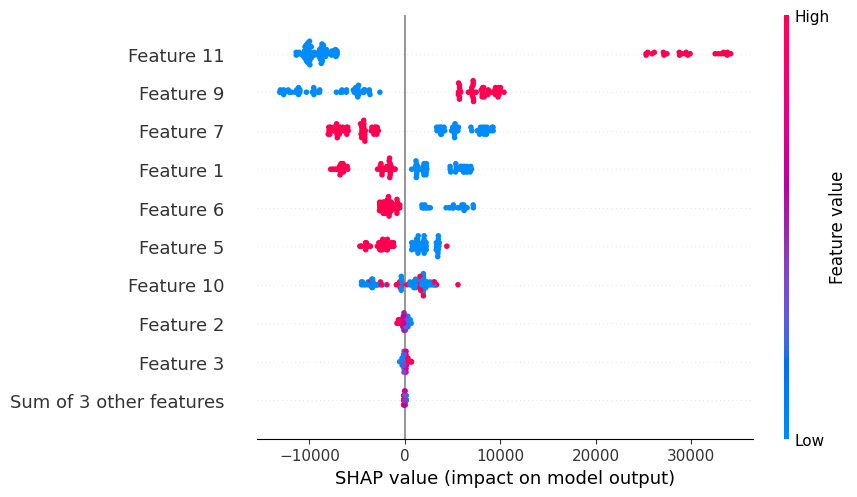

In [ ]:
shap.plots.beeswarm(shap_values)


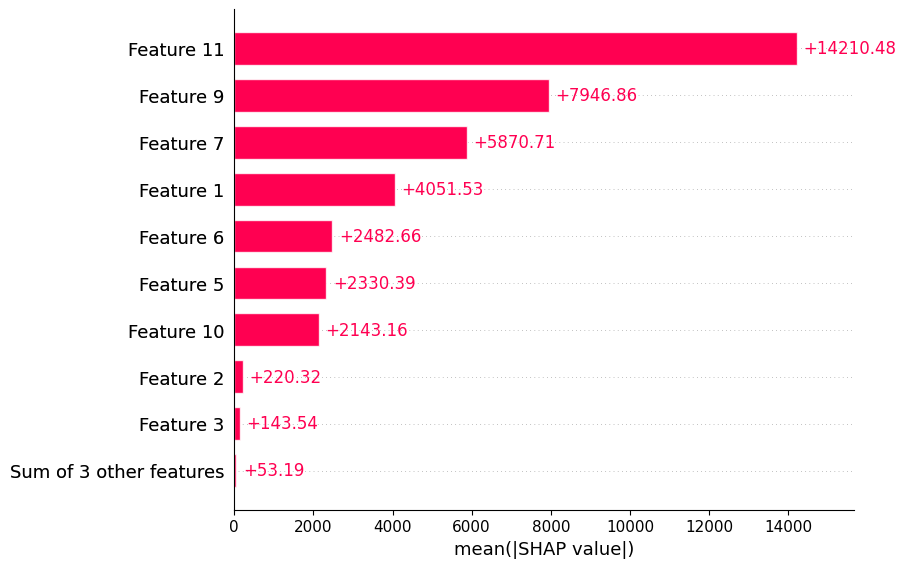

In [ ]:
shap.plots.bar(shap_values)
